<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="#GB" data-toc-modified-id="GB-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>GB</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тестирование-Linear-Regression" data-toc-modified-id="Тестирование-Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тестирование Linear Regression</a></span></li><li><span><a href="#Тестирование-Random-Forest-Regressor" data-toc-modified-id="Тестирование-Random-Forest-Regressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тестирование Random Forest Regressor</a></span></li><li><span><a href="#Тестирование-ARIMA" data-toc-modified-id="Тестирование-ARIMA-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Тестирование ARIMA</a></span></li><li><span><a href="#Тестирование-GB" data-toc-modified-id="Тестирование-GB-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Тестирование GB</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Итог</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/taxi.csv', index_col=[0], parse_dates=[0])

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Загрузили данные с преобразованием даты в индексы в соответствующем формате. Посмотрим содержимое.
</div>

In [3]:
df.isna().sum()

num_orders    0
dtype: int64

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Пропусков нет. Количество заказов разбито по десяти минутным периодам. Для надежности выполним сортировку, а потом сумируем данные по заказам укрупниф ячейки до 1-го часа.
</div>

In [5]:
df.sort_index(inplace=True)

In [6]:
df = df.resample('1H').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Готово, переходим к анализу.
</div>

## Анализ

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Визуализируем данные.
</div>

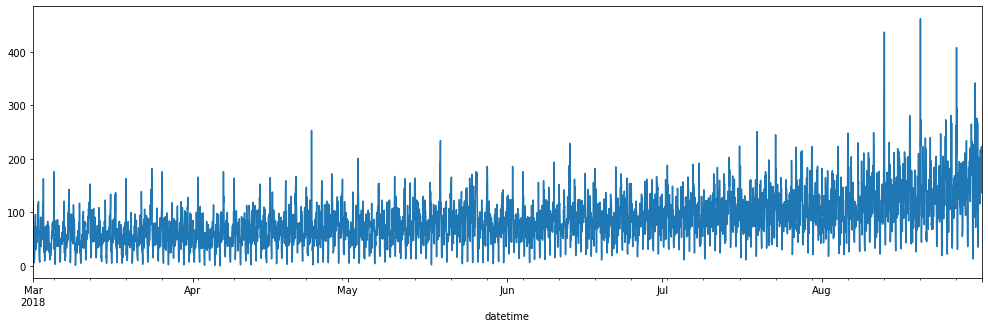

In [8]:
df['num_orders'].plot(figsize=[17,5])

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Визуально есть подозрение, что наш ряд не стационарен, построим график скользящего среднего.
</div>

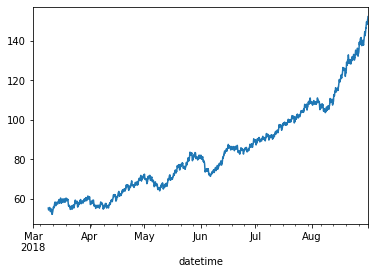

In [9]:
df['num_orders'].rolling(200).mean().plot()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Ряд однозначно не является стационарным, нужно будет учесть этот факт при обучении некоторых моделей. Визуально у нас есть тренд, подтвердим это и поищем сезонность.
</div>

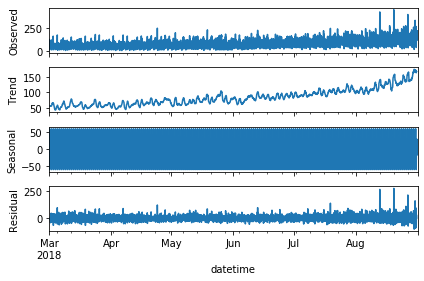

In [10]:
result = seasonal_decompose(df)
result.plot()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
В масштабе всего набора данных у нас есть тренд на возростание, так как у нас данные ключают только пол года, мы ен знаем это сезонный тренд или свидетельство развития бизнеса. В любом случае у нас прогноз будет краткосрочный (час), нанаш прогноз этот тренд не повлияет.
</div>

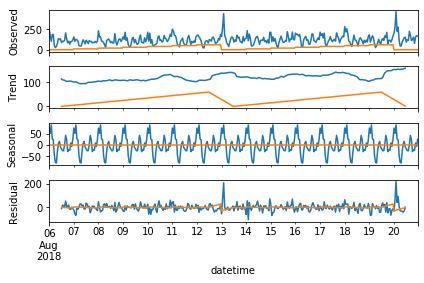

In [11]:
temp = df['2018-08-06':'2018-08-20']
temp['dayofweek'] = temp.index.dayofweek * 10
result = seasonal_decompose(temp)
result.plot()
plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Добавили информацию о дне недели (оранжева линия) и видим, что присутствует периодическое изменение количества заказов в масштабах недели. Присутствует увеличенние заказов к концу недел и при переходе на следующую неделю. Так же видна дневная сезонность, рассмотрим это в другом масштабе.
</div>

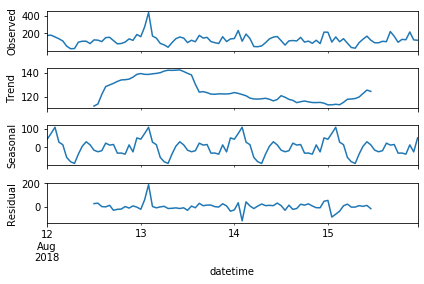

In [12]:
temp = df['2018-08-12':'2018-08-15']
result = seasonal_decompose(temp) #, model='additive')
result.plot()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Видна четкая зависимоть количества заказов от времени суток, при переходе на следующие сутки число заказов растет, а к утру идет снижение.
</div>

## Обучение

Начнем с функции создания признаков.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Наша функция создаст признаки: 'Час', 'День недели', 'Информация за N количество дней до', Скользящее среднее с определенным окном расчета среднего. На нашем промежутке времени нет смысла добавлять данные по году и месяцу, как и по дню, так как сезонность есть по неделе и по часам в сутках.
</div>

In [14]:
make_features(df, 48, 24)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Создали признаки, каждая строка будет содержать информацию о 48 часах до и среднее с окном измерения 12 часов.
</div>

In [15]:
df.head(25)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
При формировании признаков образовались пропуски в первых 24 строках фрейма, данных у нас достаточно много, поэтому просто отбросим строки с пропусками.
</div>

In [16]:
df = df.dropna()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Разделим фрейм на обучающую и тестовые выборки в соотношении 9:1. Важно убрать перемешивание из функции разделения.
</div>

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.10)

In [18]:
print('Train:', train.index.min(), train.index.max())
print('Test: ', test.index.min(), test.index.max())

Train: 2018-03-03 00:00:00 2018-08-13 18:00:00
Test:  2018-08-13 19:00:00 2018-08-31 23:00:00


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выборки не пересекаются, теперь разобьем подвыбокри на признаки и целевой признак.
</div>

In [19]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [20]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выборки подготовлены, можем переходить к обучению моделей.
</div>

### Linear Regression

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">

Создадим и обучим модель Линейной регрессии, мертикой качества у нас выступает RMSE, корень из среднеквадратичной ошибки, показывается непосредственно в количестве заказов.
</div>


In [21]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
lr_pred = lr_model.predict(features_train)

In [23]:
print("RMSE Линейной регрессии обучающей выборки:", mean_squared_error(target_train, lr_pred) ** 0.5)

RMSE Линейной регрессии обучающей выборки: 23.448938177689516


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
RMSE на обучающей выборке не показатель, отдельно в дальнейшем измерим нашу метрику на тестовой выборке. 
</div>

### Random Forest Regressor

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Следующей идет модель случайного леса. Для этого нам понадобится валидационная выборка.
</div>

In [24]:
rfgb_features_train, rfgb_features_valid = train_test_split(features_train, shuffle=False, test_size=0.10)
rfgb_target_train, rfgb_target_valid = train_test_split(target_train, shuffle=False, test_size=0.10)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Ниже код, котрорый использовался для поиска оптимальных гиперпараметров.
</div>

In [25]:
#%%time
#rf_best_model = None
#rf_rmse_best = 10000000
#rf_best_depth = 0
#rf_best_est = 0
#for est in range(30, 121, 10):
#    for depth in range(2, 14, 1):
#        rf_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
#        rf_model.fit(rfgb_features_train, rfgb_target_train)
#        rf_prediction = rf_model.predict(rfgb_features_valid)
#        rf_rmse = mean_squared_error(rfgb_target_valid, rf_prediction) ** 0.5
#        if rf_rmse < rf_rmse_best:
#            rf_best_model = rf_model
#            rf_rmse_best = rf_rmse
#            rf_best_depth = depth
#            rf_best_est = est
#        
#
#print(' RMSE =', rf_rmse_best, '\n', 'Количество деревьев =', rf_best_est, '\n', "Максимальная глубина:", rf_best_depth)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Используем полученные параметры для обучения модели.
</div>

In [26]:
rf_model = RandomForestRegressor(n_estimators=80, max_depth=5, random_state=12345)

In [27]:
%%time 
rf_model.fit(features_train, target_train)

CPU times: user 3.39 s, sys: 0 ns, total: 3.39 s
Wall time: 3.41 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [28]:
rf_pred = rf_model.predict(features_train)

print("RMSE обучающей выборки:", mean_squared_error(target_train, rf_pred) ** 0.5)

RMSE обучающей выборки: 22.14970631213338


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Опять же значение RMSE на обучающих данных не показательны, далее проверим модель на тестовой выборке.
</div>

### ARIMA

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Попробуем обучить модель ARIMA, она работает непомредственно с датами и целевым признаком, созданные нами признаки не будут использоваться с в на этом шаге.
    
Так же мы будем прогнозировать каждое значение для тестовой выборки отдельно и после каждого прогноза будем переобучать модель с добавлением настоящего значения ранее предсказанного времени.
</div>

In [29]:
%%time
history = [x for x in target_train]
predictions = list()
counter = 0

for t in range(len(target_test)):
    counter += 1
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = target_test[t]
    history.append(obs)
    #print(counter, 'predicted=%f, expected=%f' % (yhat, obs))

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1min 53s, sys: 30.5 ms, total: 1min 53s
Wall time: 1min 53s


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Вероятно существуют более оптимальные гиперпараметры, но в условиях ограниченных ресурсов были выбраны именно такие: 4 - количество предыдущих часов учитывающихся моделью, 1 - количество итераций по приведения ряда к стационарному, 0 - окно расчета среднего. Опять же проверим RMSE на тестовой выборке позднее.
</div>

### GB

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Любопытства ради в наше исследование попадает модель Градиентного бустинга, а именно LightGBM.
</div>

In [30]:
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'max_depth': 8,
    'strategy': 'recursive',
    'metric': 'rmse',
    'learning_rate': 0.05,
    "n_estimators": 500
}

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Параметры определены ручным подбором.
</div>

In [31]:
gb_model = lgb.LGBMRegressor(**params)

In [32]:
%%time
gb_model.fit(rfgb_features_train, rfgb_target_train, eval_set=[(rfgb_features_valid, rfgb_target_valid)], early_stopping_rounds=10)

[1]	valid_0's rmse: 56.3289
[2]	valid_0's rmse: 54.7807
[3]	valid_0's rmse: 53.4718
[4]	valid_0's rmse: 52.1945
[5]	valid_0's rmse: 51.0139
[6]	valid_0's rmse: 49.804
[7]	valid_0's rmse: 48.6378


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[8]	valid_0's rmse: 49.1086
[9]	valid_0's rmse: 48.0578
[10]	valid_0's rmse: 47.1317
[11]	valid_0's rmse: 46.1549
[12]	valid_0's rmse: 46.4929
[13]	valid_0's rmse: 45.5927
[14]	valid_0's rmse: 44.6651
[15]	valid_0's rmse: 43.8457
[16]	valid_0's rmse: 43.0825
[17]	valid_0's rmse: 42.4111
[18]	valid_0's rmse: 41.8468
[19]	valid_0's rmse: 41.2806
[20]	valid_0's rmse: 40.6767
[21]	valid_0's rmse: 40.8556
[22]	valid_0's rmse: 40.262
[23]	valid_0's rmse: 39.6969
[24]	valid_0's rmse: 39.2226
[25]	valid_0's rmse: 38.7695
[26]	valid_0's rmse: 38.3717
[27]	valid_0's rmse: 38.0153
[28]	valid_0's rmse: 38.2512
[29]	valid_0's rmse: 37.808
[30]	valid_0's rmse: 37.4297
[31]	valid_0's rmse: 37.577
[32]	valid_0's rmse: 37.2177
[33]	valid_0's rmse: 36.8553
[34]	valid_0's rmse: 36.5848
[35]	valid_0's rmse: 36.8047
[36]	valid_0's rmse: 37.2013
[37]	valid_0's rmse: 36.8751
[38]	valid_0's rmse: 36.5709
[39]	valid_0's rmse: 36.2882
[40]	valid_0's rmse: 36.2817
[41]	valid_0's rmse: 36.5329
[42]	valid_0's rmse

LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=8,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, strategy='recursive', subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
RMSE на валидационной выборке ~31.1, следующий шаг в нашем исследовании как раз тестирование, проверим как же хорошо прогнозируют наши модели в будущее.
</div>

## Тестирование

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
У нас есть порог заданный в условиях задачи, который мы должны превзайти, но тем не мене мы зададим порог адекватности моделей. Для этого мы посчитаем RMSE на тестовой выбрке для предсказания сделанного предыдущим значением из этой же выборки.
</div>

In [33]:
print("Среднее количество заказов в час:", df['num_orders'].mean())
pred_previous = target_test.shift(fill_value = target_train.loc[target_train.index.max()])

print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred_previous) ** 0.5)

Среднее количество заказов в час: 84.69345238095238
RMSE тестовой выборки:  59.01904048345839


<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Порог ошибки находится на уровне 59 заказов.
</div>

### Тестирование Linear Regression

In [34]:
lr_pred_test = lr_model.predict(features_test)
lr_rmse = mean_squared_error(target_test, lr_pred_test) ** 0.5

In [35]:
print("RMSE Линейной регрессии на тестовой выборке:", lr_rmse)

RMSE Линейной регрессии на тестовой выборке: 42.009308663282376


In [36]:
idx = pd.date_range('2018-08-13 19:00:00', periods=437, freq="H")
lr = pd.DataFrame(data=lr_pred_test, index=idx)

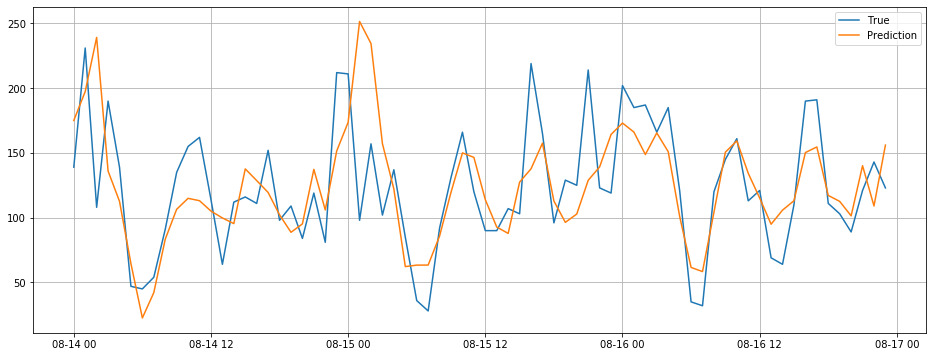

In [37]:
plt.figure(figsize=[16,6])
plt.grid()

plt.plot(target_test['2018-08-14':'2018-08-16'], label='True')
plt.plot(lr['2018-08-14':'2018-08-16'], label='Prediction')
plt.legend()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выше график сравнения реальных данных и предсказания Линейной регрессии. Направления движения Линейная регрессия предсказывает хорошо, а вот со значениями часто ошибается.
</div>

### Тестирование Random Forest Regressor

In [38]:
rf_pred_test = rf_model.predict(features_test)
rf_rmse = mean_squared_error(target_test, rf_pred_test) ** 0.5

In [39]:
print("RMSE Случайного леса на тестовой выборке", rf_rmse)

RMSE Случайного леса на тестовой выборке 46.60914238335045


In [40]:
idx = pd.date_range('2018-08-13 19:00:00', periods=437, freq="H")
rf = pd.DataFrame(data=rf_pred_test, index=idx)

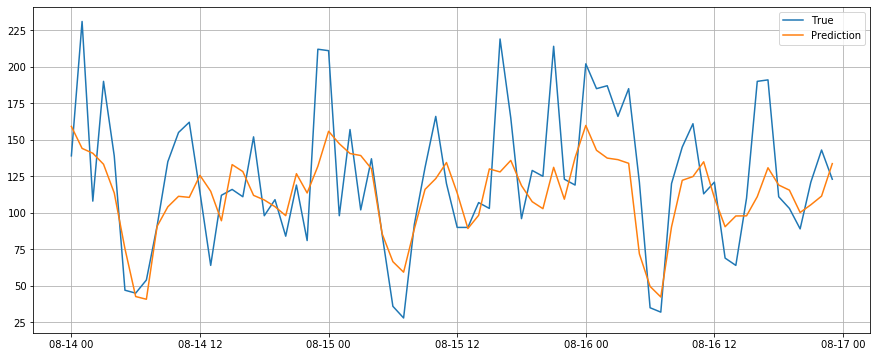

In [41]:
plt.figure(figsize=[15,6])
plt.grid()

plt.plot(target_test['2018-08-14':'2018-08-16'], label='True')
plt.plot(rf['2018-08-14':'2018-08-16'], label='Prediction')
plt.legend()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выше график сравнения реальных данных и предсказания регрессии Случайного леса. Тут предсказание направления происходит немного хуже и значения почти всегда меньше реальных.
</div>

### Тестирование ARIMA

In [42]:
ARIMA_rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE ARIMA на тестовой выборке: %.3f' % ARIMA_rmse)

RMSE ARIMA на тестовой выборке: 55.526


In [43]:
idx = pd.date_range('2018-08-13 19:00:00', periods=437, freq="H")
ar = pd.DataFrame(data=predictions, index=idx)

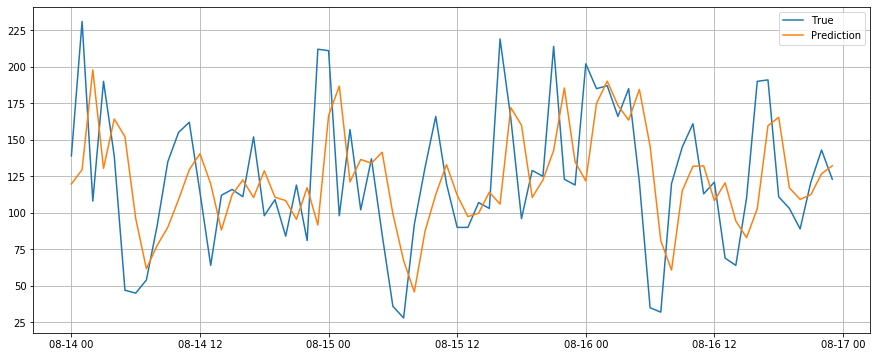

In [44]:
plt.figure(figsize=[15,6])
plt.grid()

plt.plot(target_test['2018-08-14':'2018-08-16'], label='True')
plt.plot(ar['2018-08-14':'2018-08-16'], label='Prediction')
plt.legend()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
ARIMA с нашими параметрами плохо справляется с предсказанием направления графика. Направление больше похоже на попытку отреагировать на изменения реального значения.
</div>

### Тестирование GB

In [45]:
%%time
gb_model_pred = gb_model.predict(features_test, num_iteration=gb_model.best_iteration_)

CPU times: user 55.5 ms, sys: 0 ns, total: 55.5 ms
Wall time: 66.9 ms


In [46]:
gb_rmse = mean_squared_error(target_test, gb_model_pred) ** 0.5
print("RMSE Градиентного бустинга на тестовой выборке", gb_rmse)

RMSE Градиентного бустинга на тестовой выборке 47.682111056362956


In [47]:
idx = pd.date_range('2018-08-13 19:00:00', periods=437, freq="H")
gb = pd.DataFrame(data=gb_model_pred, index=idx)

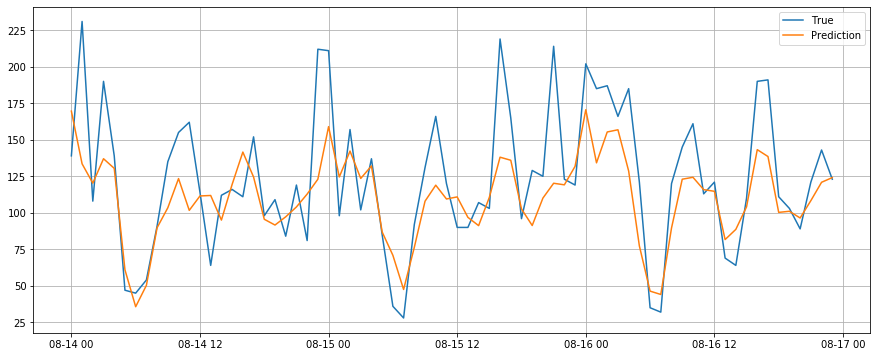

In [48]:
plt.figure(figsize=[15,6])
plt.grid()

plt.plot(target_test['2018-08-14':'2018-08-16'], label='True')
plt.plot(gb['2018-08-14':'2018-08-16'], label='Prediction')
plt.legend()

plt.show()

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Выше график сравнения реальных данных и предсказания Градиентного бустинга. Направления предсказния совпадают с направлениями изменения реальных значений, а вот конкретные значения совпадают редко.
</div>

### Итог

In [49]:
results = {'RMSE': [lr_rmse, rf_rmse, ARIMA_rmse, gb_rmse]} 

df_results = pd.DataFrame(data=results, index=["lr_rmse", "rf_rmse", "ARIMA_rmse", "gb_rmse"])

Text(0, 0.5, 'Показатели')

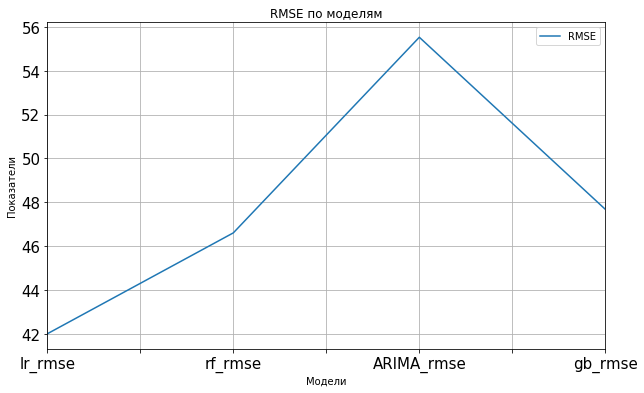

In [50]:
df_results.plot(kind='line',
        title='RMSE по моделям',
        grid=True,
        figsize=(10,6),
        fontsize=15
        )

plt.xlabel('Модели')
plt.ylabel("Показатели")

<div style="border-radius: 15px; border: 1px solid grey; padding: 15px;">
Вот так две модели из SKLearn показали самый убедительный результат на тестовой выборке, обе модели с запасом показали RMSE ниже заданного порога. В свою очередь специализированная ARIMA показала результат с трудом вписавшийся в порог адекватности модели, и не приблизиашись к заданным показателям качества. А вот градиентный бустинг вписался в заданные рамки, но результат в целом не конкурентный. В двух последних случаях допускаю улучшение качества предсказания модлей за счет изменения гиперпараметров, но в наших условиях ограниченных ресурсов провести более качественное исследование в разумные сроки сложно, да и задачи такой не стояло.
    
    
    В целом, цель исследования считаю достигнутой, лучшая модель в исследовании Random Forest Regressor.
</div>